This notebook is used to build Figures 2,3,4,5.

It is used to obtain only the first spectral gap of the tranverse-field Ising model.

In [ ]:
%pip install pennylane
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 45.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np

Functions to prepare the state and evolve it in the imaginary time.

In [ ]:
#Trotter for Ising
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]])
sigma_y = np.array([[0.0, -1j], [1j, 0.0]])
W = np.array([[1.0, -1j], [1.0, 1j]])/np.sqrt(2.)

def Ising_U(dt, J, h, hz):
  """
  Returns the unitary matrix for the Ising Trotterization.

  Args:
    dt (np.float): Trotter time step;
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.

  Returns:
     U - unitary matrix used in Trotter evolution on two neighbour sites.
  """
  H = -J*np.einsum("ij, kl -> ikjl", sigma_z, sigma_z)
  H -= h*np.einsum("ij, kl -> ikjl", sigma_x, np.eye(2))/2
  H -= h*np.einsum("ij, kl -> ikjl", np.eye(2), sigma_x)/2
  H -= hz*np.einsum("ij, kl -> ikjl", sigma_z, np.eye(2))/2
  H -= hz*np.einsum("ij, kl -> ikjl", np.eye(2), sigma_z)/2
  H = np.reshape(H, [4,4])
  d, V = np.linalg.eigh(H)
  U = np.einsum("ij, j, kj -> ik", V, np.exp(-1j*dt*d), V)
  return U

def Trotter_Ising(dt, J, h, hz, wqubits):
  """
  Applies Trotterized evolution with Ising Hamiltonian in real time.
  Note, that wqubits should be even.

  Args:
    dt (np.float): Trotter time step;
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    wqubits (np.int) : number of physical (without ancilla) qubits

  """
  N = wqubits//2
  U = Ising_U(dt, J, h, hz)
  for q in range(N):
    qml.QubitUnitary(U, wires = [2*q,2*q+1])
  for q in range(N-1):
    qml.QubitUnitary(U, wires = [2*q+1,2*q+2])
  qml.QubitUnitary(U, wires = [wqubits-1, 0])


@qml.defer_measurements
def imaginary_time_step_Ising(dt, J, h,hz, nqubits, theta0):
  """
  Applies one step of Trotterized evolution with Ising Hamiltonian in imaginery time.
  Note, that wqubits should be even.

    Args:
    dt (np.float): Trotter time step of real time evolution;
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
    theta0 (np.float): the angle of the Rz gate, as defined in arXiv:2111.12471
  """
  wqubits = nqubits - 1
  qml.Hadamard(wires = [nqubits-1])
  qml.QubitUnitary(W, wires = [nqubits-1])
  qml.ctrl(Trotter_Ising, [nqubits-1], control_values = [0])(dt, J, h, hz, wqubits)
  qml.ctrl(qml.adjoint(Trotter_Ising), [nqubits-1], control_values = [1])(dt, J, h, hz, wqubits)
  qml.RZ(-2*theta0, wires = [nqubits-1])
  qml.adjoint(qml.QubitUnitary(W, wires = [nqubits-1]))
  qml.measure(wires = [nqubits-1], postselect = 0)

def imaginary_time_evolution_Ising(steps, m0, J, h,hz, nqubits):
  """
  Applies Trotterized evolution with Ising Hamiltonian in imaginery time.
  steps controls the Trotter time steps.
  Note, that nqubits should be odd.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
  """
  s = m0/np.sqrt(1-m0**2)
  dtau = steps*s
  kappa = np.sign(m0 - 1./np.sqrt(2))
  theta0 = kappa*np.arccos((m0 + np.sqrt(1-m0**2))/np.sqrt(2))

  for c in range(len(steps)):
    dt = dtau[c]
    imaginary_time_step_Ising(dt, J, h, hz, nqubits, theta0)

def state_prep(nqubits):
  """
  Prepares the initial product state.
  You can freely change this state, it will not influence the results.

  Args:
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
  """
  wqubits = nqubits - 1
  phi_init = 0.3
  for q in range(wqubits):
    qml.Hadamard(wires = [q])
    qml.RY(phi_init, wires = [q])


In [ ]:
Nqubits = 5         #Number of qubits.
#Note, that one qubit is ancilla. Hence, the physical model is defined in
#Nqubits-1 qubits.
dev = qml.device("default.qubit", wires=Nqubits)

Functions for the imaginery time evolution, computation of energy, magnetization, and for subsequent gap estimation.

In [ ]:
@qml.qnode(dev)
def test_circuit(steps, m0, J, h, hz, nqubits):
  """
  Prepares the state, applies Trotterized evolution with Ising Hamiltonian in imaginery time.
  steps controls the Trotter time steps.
  Note, that nqubits should be odd.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.

  Returns:
    density_matrix - density matrix of the system on the physical qubits.
  """
  state_prep(nqubits)
  imaginary_time_evolution_Ising(steps, m0, J, h, hz, nqubits)
  return qml.density_matrix(wires = range(nqubits-1))

@qml.qnode(dev)
def test_energy(steps, m0, J, h, hz, nqubits):
  """
  Finds the ground state energy with imaginary time evolution.
  Prepares the state and Hamiltonian. Evolves the state in imaginary time.
  Measures the Hamiltonian.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.

  Returns:
    expval(H) - expectation value of the Ising Hamiltonian.
  """
  ZZ = [qml.PauliZ(i)@qml.PauliZ((i+1)%(nqubits-1)) for i in range(nqubits-1)]
  ZZ_coeff = [-J for i in range(nqubits-1)]
  X = [qml.PauliX(i) for i in range(nqubits-1)]
  X_coeff = [-h for i in range(nqubits-1)]
  Z = [qml.PauliZ(i) for i in range(nqubits-1)]
  Z_coeff = [-hz for i in range(nqubits-1)]
  obs = ZZ + X + Z
  coeffs = ZZ_coeff + X_coeff + Z_coeff
  H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")
  state_prep(nqubits)
  imaginary_time_evolution_Ising(steps, m0, J, h, hz, nqubits)
  return qml.expval(H)

@qml.qnode(dev)
def magnetization_Z(step, m0, J, h, hz, nqubits):
  """
  Finds the magnetization with imaginery time optimization.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.

  Returns:
    expval(M) - expectation value of the magnetization in Z direction.
  """
  Z = [qml.PauliZ(i) for i in range(nqubits-1)]
  Z_coeff = [1.0 for i in range(nqubits-1)]

  M = qml.Hamiltonian(Z_coeff, Z, grouping_type="qwc")
  state_prep(nqubits)
  imaginary_time_evolution_Ising(steps, m0, J, h, hz, nqubits)
  return qml.expval(M)

def gap_operators(steps, m0, J, h, hz, nqubits):
  """
  Finds the [H,O] expectation value.
  O = \sum_{i} \sigma_{i}^{y}
  Two such expectations for different imaginary times can be used to estimate
  the gap.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    hz (np.float) : the coefficient of the transverse magnetic field term in Z direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.

  Returns:
    expt_HO - expectation value of the commutator [H,O] for the final time.
  """
  rdm = test_circuit(steps, m0, J, h, hz, nqubits)
  obs = []
  coeffs = []
  for c in range(nqubits - 1):
    obs += [qml.PauliZ(c), qml.PauliX(c), qml.PauliX(c)@qml.PauliZ((c+1)%(nqubits-1)), qml.PauliZ((c-1)%(nqubits-1))@qml.PauliX(c)]
    coeffs += [-h, hz, J, J]
  HO = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")
  HOm = HO.sparse_matrix().todense()
  expt_HO = np.einsum("ij,ji ->", HOm, rdm)

  return expt_HO



Test of the ground state energy computation. Figure 2.

Optimized energy is -4.022456314875726.
Exact ground state energy is: -4.0405936992038605


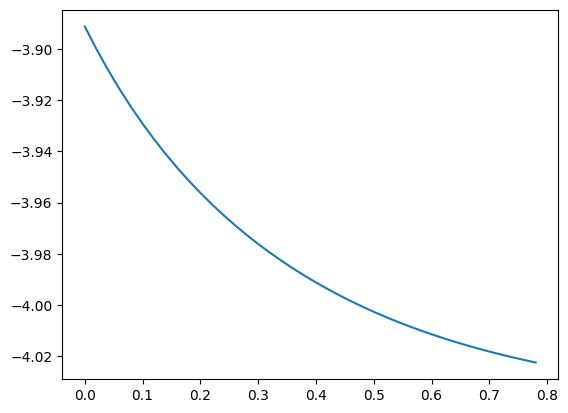

In [ ]:
step = 0.02                #Trotter time step.
m0 = 0.8                   #Additional parameter for the algorithm.
J = 0.2                    #Ising model parameters
h = 1.0
hz = 0.0
E = []
for nsteps in range(40):
  steps = step*np.ones(nsteps)
  Eg = test_energy(steps, m0, J, h, hz, Nqubits)
  E.append(Eg)

plt.plot(step*np.arange(40), E)
print(f"Optimized energy is {Eg}.")

ZZ = [qml.PauliZ(i)@qml.PauliZ((i+1)%(Nqubits-1)) for i in range(Nqubits-1)]
ZZ_coeff = [-J for i in range(Nqubits-1)]
X = [qml.PauliX(i) for i in range(Nqubits-1)]
X_coeff = [-h for i in range(Nqubits-1)]
Z = [qml.PauliZ(i) for i in range(Nqubits-1)]
Z_coeff = [-hz for i in range(Nqubits-1)]
obs = ZZ + X + Z
coeffs = ZZ_coeff + X_coeff + Z_coeff
H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")

Hs = H.sparse_matrix()
M = Hs.todense()
d = np.sort(np.real(np.linalg.eigvals(M)))

print(f"Exact ground state energy is: {d[0]}")


Computation of magnetization:

In [ ]:
step = 0.02
m0 = 0.8
J = 0.2
h = 1.0
hz = 0.0
nsteps = 60
steps = step*np.ones(nsteps)
M = magnetization_Z(steps, m0, J, h, hz, Nqubits)

print(f"Magnetization in Z direction is {M/(Nqubits-1)}.")

Magnetization in Z direction is -0.06764709885704982.


Magnetization has successfully converged to near zero, as it should be in paramagnetic phase.

Let us start computing the gap. First we show that the commutator decays exponentially. Figure 3.

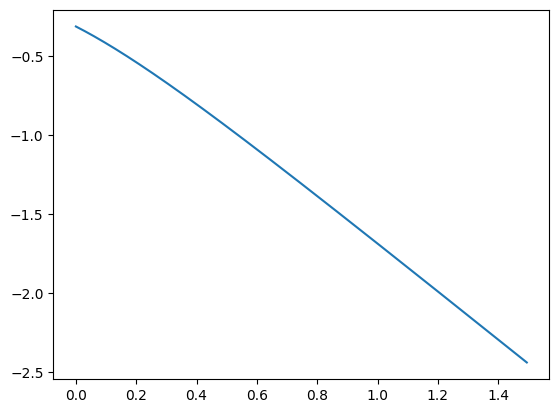

In [ ]:
step = 0.005
gap_est = []
for nsteps in range(300):
  steps = step*np.ones(nsteps)
  est = gap_operators(steps, m0, J, h, hz, Nqubits)
  gap_est.append(est)

plt.plot(step*np.arange(300), np.log(np.abs(gap_est)))

We see a clear linear regime on this plot (which corresponds to exponential decay due to logarithm).

We can also find the numerical derivative of the logarithm: (Figure 4)

Estimated energy gap is: 1.5261117067637109
Exact energy gap is: 1.6009858937667434


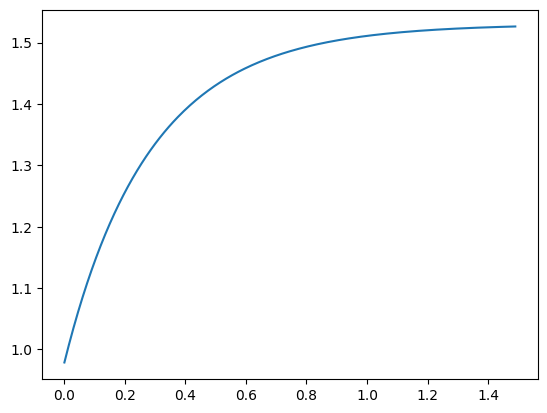

In [ ]:
gap_estimation = np.diff(np.log(np.real(gap_est)))/step
plt.plot(step*np.arange(299), -gap_estimation)
print(f"Estimated energy gap is: {-gap_estimation[-1]}")
print(f"Exact energy gap is: {d[1] -d[0]}")

We have extracted the gap from the derivative. Note, that there is a discrepancy in the result. This is largely caused by the errors in the approximation of the imaginery time evolution. There are two sources of such error: errors in the Trotterized evolution in the real time and errors in the algorithm, which does not exactly transform real time evolution into the imaginery time.

Both these errors can be reduced with decrease in the Trotter step. Below we also show the hybrid scheme, where we first optimize the ground state with large Trotter step, and then make a small several step optimization with small Trotter steps to extract the gap more reliable.

In [ ]:
nsteps = 70

step1 = 0.02       #Large time step for preliminary optimization
steps = step1*np.ones(nsteps)
est1 = gap_operators(steps, m0, J, h, hz, Nqubits)

step2 = 0.003      #Small time step for gap extraction.
steps = np.append(steps, step2)
est2 = gap_operators(steps, m0, J, h, hz, Nqubits)

gap = -np.log(np.abs(est2/est1))/step2

print(f"The gap estimation is {gap}")
print(f"Exact energy gap is: {d[1] -d[0]}")
print(f"The error is: {100*(d[1] -d[0]-gap)/gap} %")

The gap estimation is 1.5490100127602018
Exact energy gap is: 1.6009858937667434
The error is: 3.3554257608654887 %


In [ ]:
nsteps = 70

step1 = 0.02       #Large time step for preliminary optimization
steps = step1*np.ones(nsteps)
est1 = gap_operators(steps, m0, J, h, hz, Nqubits)

step2 = 0.002      #Small time step for gap extraction.
steps = np.append(steps, step2)
est2 = gap_operators(steps, m0, J, h, hz, Nqubits)

gap1 = -np.log(np.abs(est2/est1))/step2

print(f"The gap estimation is {gap1}")
print(f"Exact energy gap is: {d[1] -d[0]}")
print(f"The error is: {100*(d[1] -d[0]-gap1)/gap1} %")

The gap estimation is 1.563091358929987
Exact energy gap is: 1.6009858937667434
The error is: 2.4243326930485356 %


In [ ]:
nsteps = 70

step1 = 0.02       #Large time step for preliminary optimization
steps = step1*np.ones(nsteps)
est1 = gap_operators(steps, m0, J, h,hz, Nqubits)

step2 = 0.001      #Small time step for gap extraction.
steps = np.append(steps, step2)
est2 = gap_operators(steps, m0, J, h,hz, Nqubits)

gap2 = -np.log(np.abs(est2/est1))/step2

print(f"The gap estimation is {gap2}")
print(f"Exact energy gap is: {d[1] -d[0]}")
print(f"The error is: {100*(d[1] -d[0]-gap2)/gap2} %")

The gap estimation is 1.5772635957688053
Exact energy gap is: 1.6009858937667434
The error is: 1.5040160732534482 %


We have find the gap to within two percent accuracy. Note, that the increase in the accuracy of imaginery time evolution implementation will result in much more accurate gaps. E.g. with tensor networks methods we were generally able to extract the gap to 0.1% accuracy, with 0.01 time step. The difference was that we have used Trotterized imaginery time evolution, not the real time transformed into the imaginery.

It seems that the error scales linearly in time step. Perhaps, we can also use this to extrapolate the results:

In [ ]:
gap_extrapolated = gap2 + (gap2 - gap1)

Much more accurate estimation:

In [ ]:
print(f"The error is: {100*(d[1] -d[0]-gap_extrapolated)/gap_extrapolated} %")

The error is: 0.6000908716169742 %


Let us now show that the error in the gap really depends linearly on the trotter step. We will also use non-trivial $h_{z}$, to show that our results do not depend upon the explicit breaking of the spin symmetry.

In [ ]:
step = 0.02                #Trotter time step.
m0 = 0.8                   #Additional parameter for the algorithm.
J = 0.4                    #Ising model parameters
h = 1.0
hz = 0.1

ZZ = [qml.PauliZ(i)@qml.PauliZ((i+1)%(Nqubits-1)) for i in range(Nqubits-1)]
ZZ_coeff = [-J for i in range(Nqubits-1)]
X = [qml.PauliX(i) for i in range(Nqubits-1)]
X_coeff = [-h for i in range(Nqubits-1)]
Z = [qml.PauliZ(i) for i in range(Nqubits-1)]
Z_coeff = [-hz for i in range(Nqubits-1)]
obs = ZZ + X + Z
coeffs = ZZ_coeff + X_coeff + Z_coeff
H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")

Hs = H.sparse_matrix()
M = Hs.todense()
d = np.sort(np.real(np.linalg.eigvals(M)))

In [ ]:
nsteps = 60

gaps = []
for step2 in np.linspace(0.001, 0.02, 10):
  step1 = 0.04       #Large time step for preliminary optimization
  steps = step1*np.ones(nsteps)
  est1 = gap_operators(steps, m0, J, h,hz, Nqubits)

  # step2 = 0.001      #Small time step for gap extraction.
  steps2 = np.append(steps, step2)
  est2 = gap_operators(steps2, m0, J, h,hz, Nqubits)

  gap2 = -np.log(np.abs(est2/est1))/step2
  gaps.append(gap2)

  print(f"Step is {step2}")
  print(f"The gap estimation is {gap2}")
  # print(f"Exact energy gap is: {d[1] -d[0]}")
  print(f"The error is: {100*(d[1] -d[0]-gap2)/gap2} %")

Step is 0.001
The gap estimation is 1.2579223394792978
The error is: 2.062263347830973 %
Step is 0.003111111111111111
The gap estimation is 1.231682115519035
The error is: 4.236636600794732 %
Step is 0.005222222222222222
The gap estimation is 1.2058337819242124
The error is: 6.47106011425786 %
Step is 0.007333333333333333
The gap estimation is 1.1803634972276613
The error is: 8.768528834209905 %
Step is 0.009444444444444443
The gap estimation is 1.1552579572424262
The error is: 11.132236984985646 %
Step is 0.011555555555555555
The gap estimation is 1.1305043667884274
The error is: 13.565595016479133 %
Step is 0.013666666666666667
The gap estimation is 1.106090413130905
The error is: 16.07224830712033 %
Step is 0.015777777777777776
The gap estimation is 1.0820042410064032
The error is: 18.65609783898799 %
Step is 0.017888888888888888
The gap estimation is 1.0582344291279793
The error is: 21.321323091756174 %
Step is 0.02
The gap estimation is 1.0347699680611349
The error is: 24.07240743

Finally we plot the estimated gap against the Trotter step:(Figure 5)

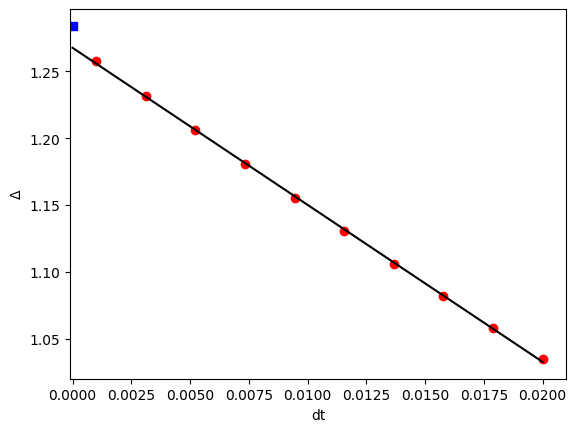

In [ ]:
plt.plot(np.linspace(0.001, 0.02, 10), gaps, 'ro')
slope, intercept = np.linalg.lstsq(np.vstack([np.linspace(0.001, 0.02, 10), np.ones(10)]).T, gaps, rcond=None)[0]

plt.plot(np.linspace(0.0, 0.02, 100), slope*np.linspace(0.0, 0.02, 100)+intercept, 'k')
plt.xlim(-0.0001, 0.021)
plt.xlabel("dt")
plt.ylabel(r"$\Delta$")

plt.plot([0.0], [d[1]-d[0]], 'bs')
plt.savefig("Gap_fit.pdf")
